In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

overleaf_dir = "/Users/guanlil1/Dropbox/应用/Overleaf/DataWorkloadGen/figures/"

def generate_drifted_2d_data_split_base(base_count=2000, injection_counts=[500, 200],
                                        injection_means=[(0, 0), (2, 2)],
                                        stds=[0.5, 1.0],
                                        distributions=["normal", "uniform"]):
    """
    Split a portion of base_data to serve as the first injection (same distribution),
    then apply a different distribution for the second injection.
    """
    np.random.seed(42)
    base_data = np.random.randn(base_count, 2)
    np.random.shuffle(base_data)

    # Split out first injection from base_data
    inject1_count = injection_counts[0]
    injection1 = base_data[:inject1_count]
    remaining_base = base_data[inject1_count:]

    all_data = [remaining_base]
    labels = ['Base', 'Drift 1']

    # Second injection: custom distribution
    count2 = injection_counts[1]
    mean2 = injection_means[1]
    std2 = stds[1]
    dist2 = distributions[1]

    if dist2 == "normal":
        injection2 = np.random.randn(count2, 2) * std2 + np.array(mean2)
    elif dist2 == "uniform":
        injection2 = np.random.rand(count2, 2) * std2 + np.array(mean2)
    elif dist2 == "laplace":
        injection2 = np.random.laplace(loc=mean2, scale=std2, size=(count2, 2))
    else:
        raise ValueError(f"Unsupported distribution type: {dist2}")

    all_data.append(injection1)
    all_data.append(injection2)
    labels.append(f"Drift 2")

    return all_data, labels


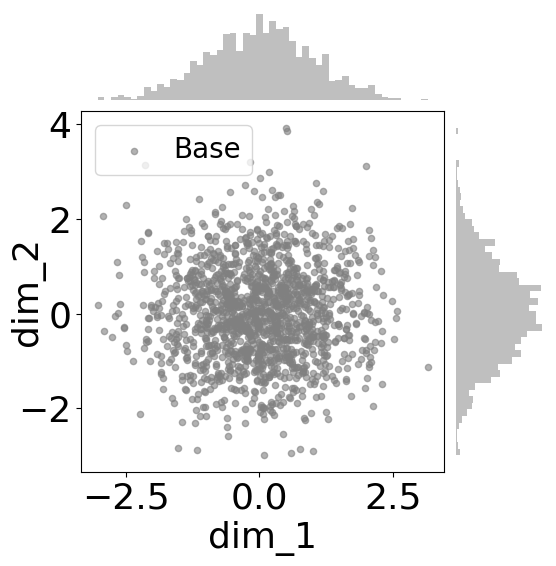

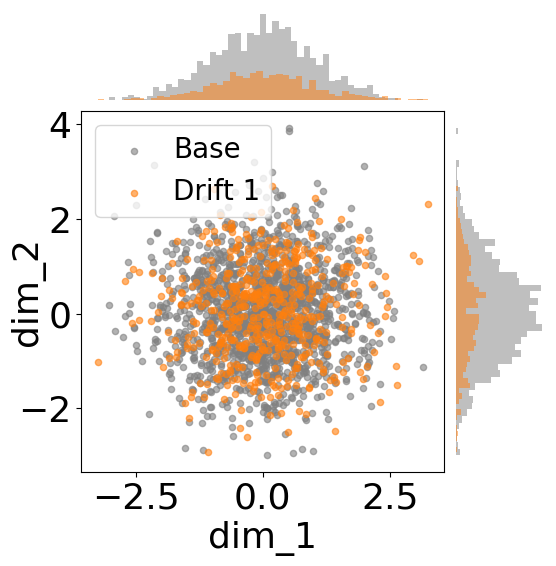

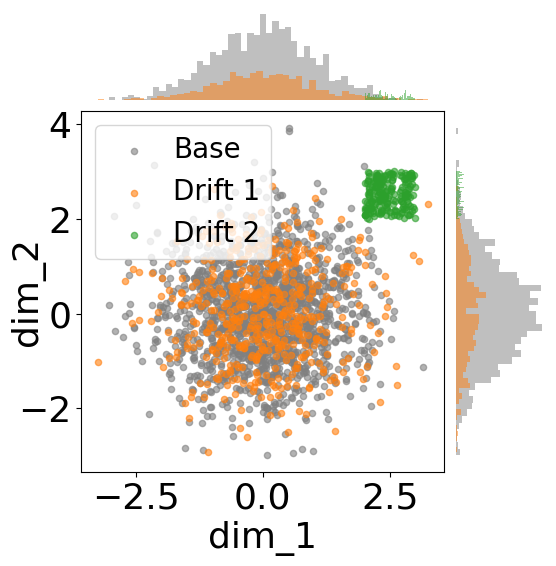

In [2]:
fontsize_title=30
fontsize_legend=20
fontsize_ticks=26

def plot_drift_with_diff_marginals(all_data, labels, save_dir="drift_diff_marginals", base_color="gray", drift_colors=None, titles=None):
    os.makedirs(save_dir, exist_ok=True)
    if drift_colors is None:
        drift_colors = [f"C{i}" for i in range(len(all_data))]

    for i in range(len(all_data)):
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                      wspace=0.05, hspace=0.05)
        ax_main = fig.add_subplot(gs[1, 0])
        ax_x = fig.add_subplot(gs[0, 0], sharex=ax_main)
        ax_y = fig.add_subplot(gs[1, 1], sharey=ax_main)

        x_all, y_all = [], []
        all_colors = []

        for j in range(i + 1):
            data = all_data[j]
            x_all.append(data[:, 0])
            y_all.append(data[:, 1])
            color = base_color if j == 0 else drift_colors[j]
            all_colors.append(color)
            ax_main.scatter(data[:, 0], data[:, 1], color=color, label=labels[j], alpha=0.6, s=20)

        # Plot separate histograms for each layer
        for x, color in zip(x_all, all_colors):
            ax_x.hist(x, bins=50, color=color, alpha=0.5, histtype='stepfilled')

        for y, color in zip(y_all, all_colors):
            ax_y.hist(y, bins=50, orientation='horizontal', color=color, alpha=0.5, histtype='stepfilled')

        ax_x.axis('off')
        ax_y.axis('off')
        ax_main.set_xlabel("dim_1", fontsize=fontsize_ticks)
        # ax_main.set_ylabel("dim-2", fontsize=fontsize_ticks, labelpad=0)
        ax_main.set_ylabel("dim_2", fontsize=fontsize_ticks)
        ax_main.yaxis.set_label_coords(-0.1, 0.5) 

        ax_main.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        
        if titles:
            ax_main.set_title(titles[i], fontsize=fontsize_title)
        # else:
        #     ax_main.set_title(f"Stage {i}")
        # ax_main.legend(fontsize=fontsize_legend,loc="upper left")
        ax_main.legend(fontsize=fontsize_legend, loc="upper left", handletextpad=0.4)


        save_path = os.path.join(save_dir, f"data_drift_diff_stage_{i}.pdf")
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        plt.savefig(os.path.join(overleaf_dir, f"data_drift_diff_stage_{i}.pdf"), format='pdf', bbox_inches='tight')
        
        plt.show()
        plt.close()

# titles = ["time $t_0$", "time $t_1$", "time $t_2$"]
# Generate and save with differential marginal histograms
all_data, labels = generate_drifted_2d_data_split_base()
plot_drift_with_diff_marginals(all_data, labels, save_dir="drift_diff_marginals", titles=[])


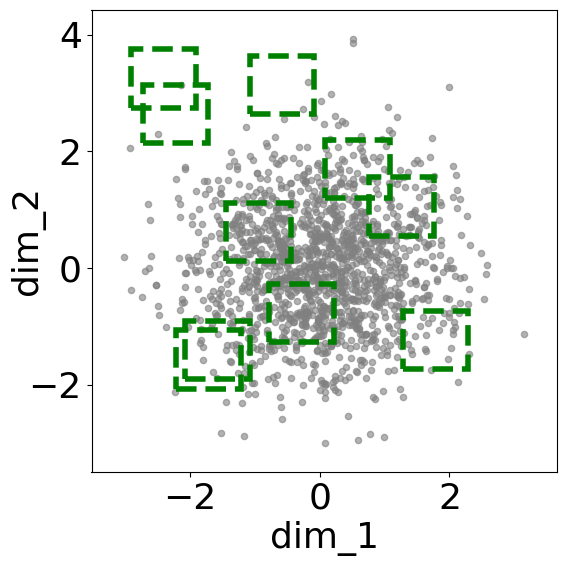

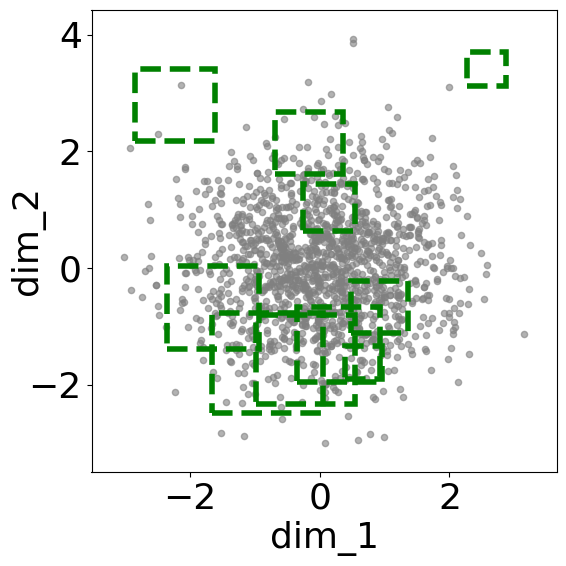

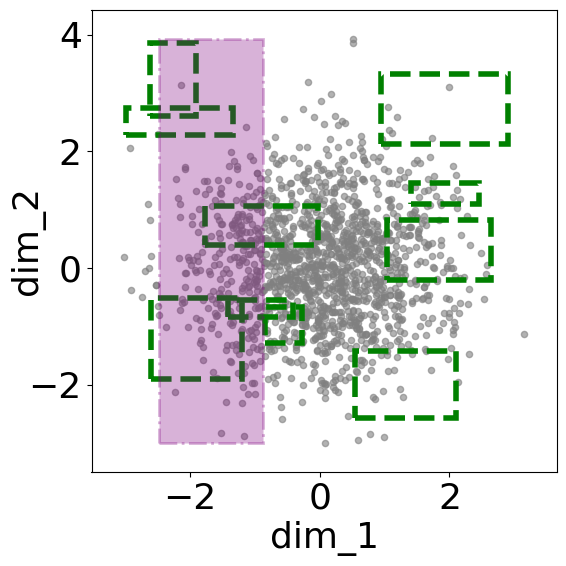

In [4]:
# Get data bounds and constrain query rectangles to fall within this range
from matplotlib.patches import Rectangle

base_data_only = all_data[0]

# Compute bounding box for the base data
x_min, x_max = base_data_only[:, 0].min(), base_data_only[:, 0].max()
y_min, y_max = base_data_only[:, 1].min(), base_data_only[:, 1].max()

def plot_query_shapes_within_bounds(base_data, x_min, x_max, y_min, y_max, save_dir="query_shape_drift_clipped"):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(overleaf_dir, exist_ok=True)

    np.random.seed(42)
    fig_titles = ["Uniform Square Queries", "Variable Size Squares", "Rectangular Queries"]

    for stage in range(3):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(base_data[:, 0], base_data[:, 1], color="gray", alpha=0.6, s=20, label="Base Data")

        for _ in range(10):
            if stage == 0:
                w = h = 1.0
            elif stage == 1:
                w = h = np.random.uniform(0.5, 2.0)
            else:
                w = np.random.uniform(0.5, 2.0)
                h = np.random.uniform(0.2, 1.5)

            cx = np.random.uniform(x_min + w/2, x_max - w/2)
            cy = np.random.uniform(y_min + h/2, y_max - h/2)

            rect = Rectangle((cx - w/2, cy - h/2), w, h,
                             linewidth=4, edgecolor='green', facecolor='none', linestyle='--')
            ax.add_patch(rect)

        if stage == 2:
            cx = np.random.uniform(x_min + w/2, x_max - w/2)
            rect = Rectangle((cx - w/2, y_min), w, y_max - y_min,
                             linewidth=2, alpha=0.3, edgecolor='purple', facecolor='purple', linestyle='-.')
            ax.add_patch(rect)

        
        # ax.set_title(fig_titles[stage], fontsize=fontsize_title)
        ax.set_xlabel("dim_1", fontsize=fontsize_ticks)
        ax.set_ylabel("dim_2", fontsize=fontsize_ticks)
        ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        # ax.legend(fontsize=12, loc="upper left", handletextpad=0.4)
        ax.yaxis.set_label_coords(-0.1, 0.5) 

        ax.set_xlim(x_min - 0.5, x_max + 0.5)
        ax.set_ylim(y_min - 0.5, y_max + 0.5)

        save_path = os.path.join(save_dir, f"query_shape_stage_{stage}.pdf")
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        plt.savefig(os.path.join(overleaf_dir, f"query_shape_stage_{stage}.pdf"), format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()

plot_query_shapes_within_bounds(base_data_only, x_min, x_max, y_min, y_max)


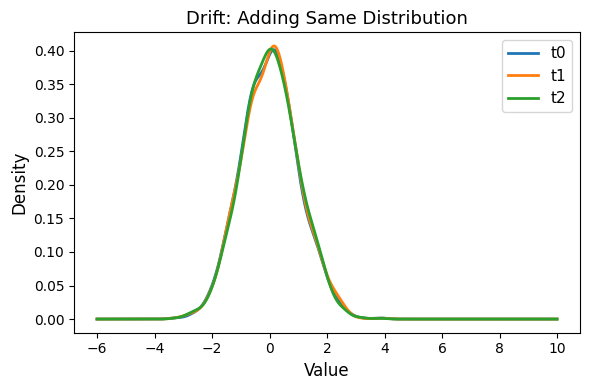

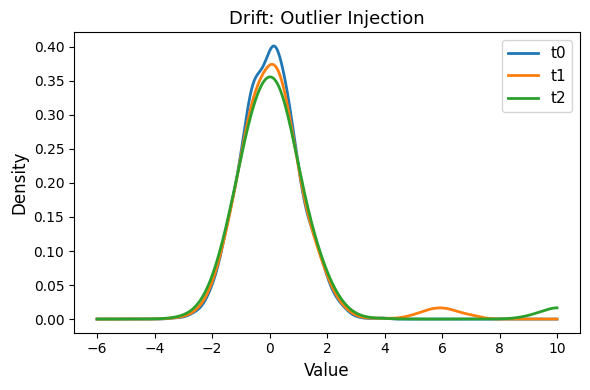

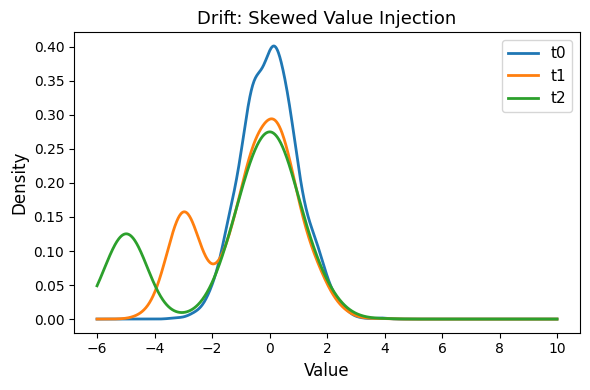

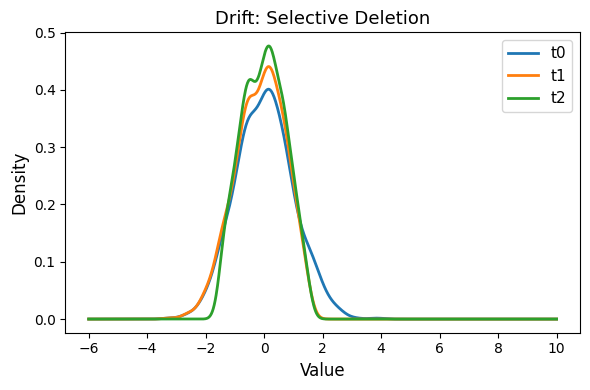

In [5]:
# 为每种 drift 类型生成三阶段版本：t0 (base), t1 (moderate drift), t2 (stronger drift)

from scipy.stats import gaussian_kde
# Base distribution
np.random.seed(42)
base_data = np.random.normal(loc=0, scale=1.0, size=1000)

# 1. Same Distribution Increment
same_t1 = np.concatenate([base_data, np.random.normal(loc=0, scale=1.0, size=300)])
same_t2 = np.concatenate([base_data, np.random.normal(loc=0, scale=1.0, size=600)])

# 2. Outlier Injection
outlier_t1 = np.concatenate([base_data, np.random.normal(loc=6, scale=0.5, size=30)])
outlier_t2 = np.concatenate([base_data, np.random.normal(loc=10, scale=0.5, size=30)])

# 3. Skewed Value Injection
skewed_t1 = np.concatenate([base_data, np.random.normal(loc=-3, scale=0.5, size=300)])
skewed_t2 = np.concatenate([base_data, np.random.normal(loc=-5, scale=0.5, size=300)])

# 4. Selective Deletion (t1: remove right tail, t2: remove both tails)
deleted_t1 = base_data[base_data < 1.5]
deleted_t2 = deleted_t1[deleted_t1 > -1.5]

output_dir = "tsne_drift_types_data"


# 通用三阶段绘图函数
def plot_triple_drift(base, t1, t2, title, save_name):
    os.makedirs(output_dir, exist_ok=True)
    xs = np.linspace(-6, 10, 1000)
    plt.figure(figsize=(6, 4))
    for data, label in zip([base, t1, t2], ["t0", "t1", "t2"]):
        kde = gaussian_kde(data)
        plt.plot(xs, kde(xs), label=label, linewidth=2)
    plt.title(title, fontsize=13)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, save_name), format="pdf", bbox_inches="tight")
    plt.savefig(os.path.join(overleaf_dir, save_name), format='pdf', bbox_inches='tight')
    
    plt.show()

# 绘图执行
plot_triple_drift(base_data, same_t1, same_t2,
                  "Drift: Adding Same Distribution", "drift_add_same_dist_3stage.pdf")

plot_triple_drift(base_data, outlier_t1, outlier_t2,
                  "Drift: Outlier Injection", "drift_outlier_injection_3stage.pdf")

plot_triple_drift(base_data, skewed_t1, skewed_t2,
                  "Drift: Skewed Value Injection", "drift_skewed_value_3stage.pdf")

plot_triple_drift(base_data, deleted_t1, deleted_t2,
                  "Drift: Selective Deletion", "drift_selective_deletion_3stage.pdf")


/Users/guanlil1/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


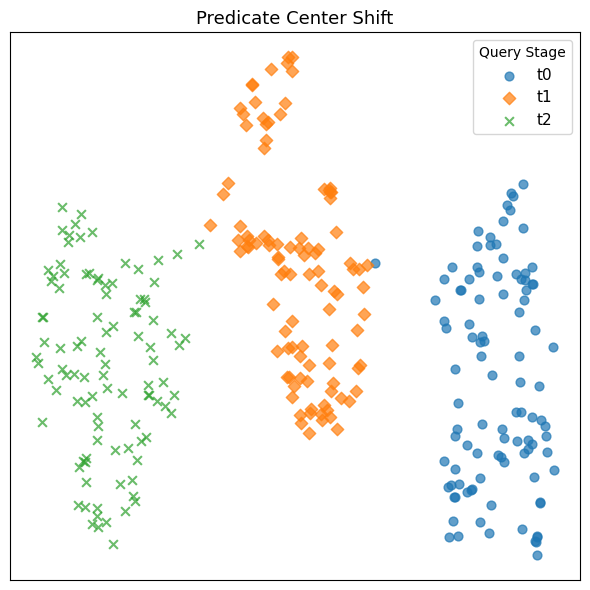

/Users/guanlil1/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


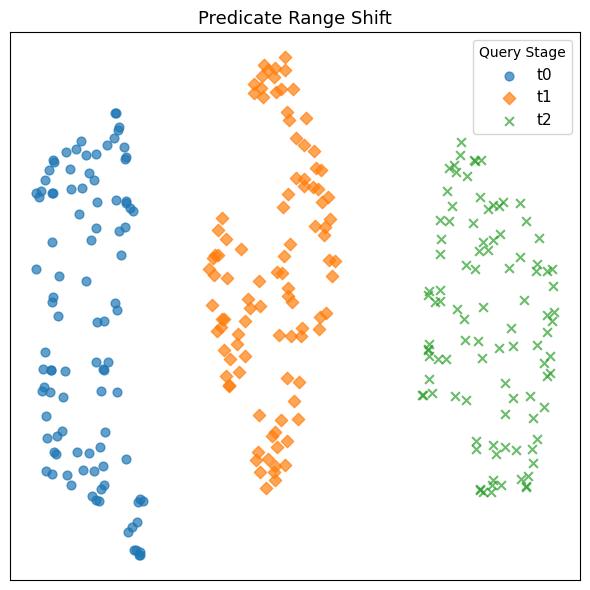

/Users/guanlil1/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


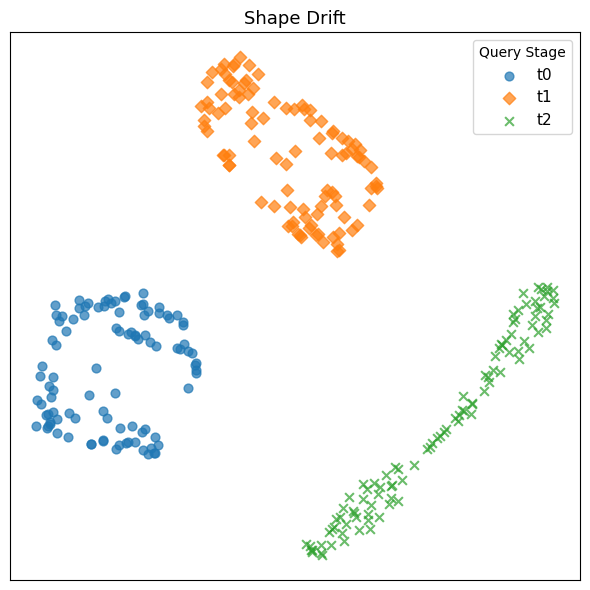

/Users/guanlil1/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


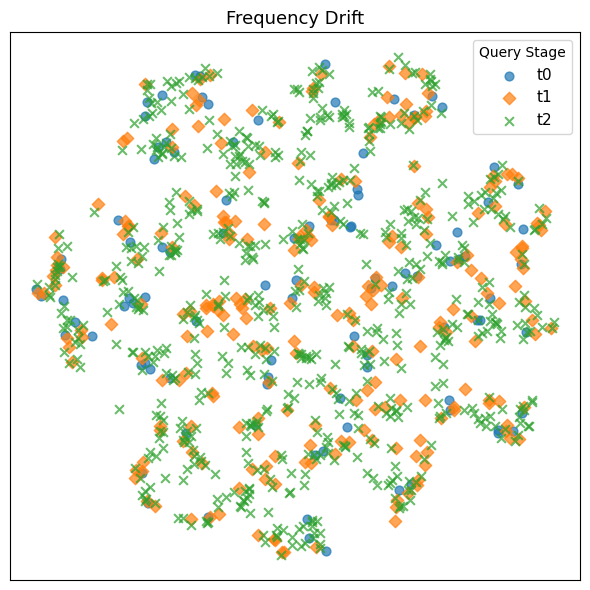

[[0.24835707650561634, 1.0, -0.06913215058559233, 1.0], [-0.11707668736166799, 1.0, -0.11706847847459027, 1.0], [0.7896064077536957, 1.0, 0.3837173645764544, 1.0], [-0.23473719296747605, 1.0, 0.27128002179298233, 1.0], [0.12098113578301706, 1.0, -0.956640122328899, 1.0], [-0.5064155601672119, 1.0, 0.15712366629763694, 1.0], [0.732824384460777, 1.0, -0.11288815024326783, 1.0], [-0.27219136226259133, 1.0, 0.05546129485493304, 1.0], [-0.3003193449594025, 1.0, -0.1458468748966384, 1.0], [-0.0067486123689669605, 1.0, -0.5288554644779502, 1.0], [0.4112724560515945, 1.0, -0.6104218249855111, 1.0], [-0.6640930244492153, 1.0, 0.09843061793456176, 1.0], [0.3692332899977052, 1.0, 0.08568414059498525, 1.0], [-0.057824141194120264, 1.0, -0.1505518477946444, 1.0], [-0.23031938547989375, 1.0, 0.5285611131094579, 1.0], [0.1620419846973975, 1.0, -0.19254114020815827, 1.0], [-0.33846100015297936, 1.0, 0.30583814442043394, 1.0], [0.5154997612479755, 1.0, 0.4656400595580993, 1.0], [-0.41960876161131927, 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# 设置输出目录
output_dir = "tsne_drift_types"
os.makedirs(output_dir, exist_ok=True)

# 通用 t-SNE 可视化函数
def plot_tsne(embedding, labels, title, save_name):
    embedding = np.array(embedding)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, init="pca", learning_rate="auto", random_state=42)
    embedding_2d = tsne.fit_transform(embedding)

    # 阶段与 marker 映射
    stage_marker_map = {
        "t0": "o",  # circle
        "t1": "D",  # square
        "t2": "x",  # diamond
    }

    plt.figure(figsize=(6, 6))
    for stage in sorted(set(labels)):
        idx = [i for i, l in enumerate(labels) if l == stage]
        marker = stage_marker_map.get(stage, "o")
        plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1],
                    label=stage, s=40, alpha=0.7, marker=marker)

    plt.legend(title="Query Stage", fontsize=11)
    plt.title(title, fontsize=13)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, save_name), format="pdf", bbox_inches="tight")
    plt.savefig(os.path.join(overleaf_dir, save_name), format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

# 每种 drift 都生成 t0, t1, t2 三阶段，每阶段 100 个查询
n_queries_per_stage = 100
np.random.seed(42)


# 重新定义所有 vectors 和 labels 变量并调用绘图函数

# 1. Predicate Center Shift
center_vectors = []
center_labels = []
for label, (cx, cy) in zip(["t0", "t1", "t2"], [(0, 0), (2, 2), (4, 4)]):
    for _ in range(n_queries_per_stage):
        x_center = np.random.normal(cx, 0.5)
        y_center = np.random.normal(cy, 0.5)
        x_range = np.random.uniform(1.0, 1.0)
        y_range = np.random.uniform(1.0, 1.0)
        center_vectors.append([x_center, x_range, y_center, y_range])
        center_labels.append(label)

# 2. Predicate Range Shift
range_vectors = []
range_labels = []
for label, r in zip(["t0", "t1", "t2"], [0.5, 1.0, 2.0]):
    for _ in range(n_queries_per_stage):
        x_center = np.random.uniform(2, 2)
        y_center = np.random.uniform(2, 2)
        x_range = np.random.uniform(r * 0.8, r * 1.2)
        y_range = np.random.uniform(r * 0.8, r * 1.2)
        range_vectors.append([x_center, x_range, y_center, y_range])
        range_labels.append(label)

# 3. Shape Drift
shape_vectors = []
shape_labels = []
for label, (xr, yr) in zip(["t0", "t1", "t2"], [(1.0, 1.0), (2.0, 1.0), (3.0, 0.5)]):
    for _ in range(n_queries_per_stage):
        x_center = np.random.uniform(2, 2)
        y_center = np.random.uniform(2, 2)
        x_range = np.random.uniform(xr * 0.8, xr * 1.2)
        y_range = np.random.uniform(yr * 0.8, yr * 1.2)
        shape_vectors.append([x_center, x_range, y_center, y_range])
        shape_labels.append(label)

# 4. Frequency Drift
frequency_vectors = []
frequency_labels = []

for _ in range(n_queries_per_stage):
    x_center = np.random.normal(2, 0.5)
    y_center = np.random.normal(2, 0.5)
    x_range = np.random.uniform(1.0, 1.0)
    y_range = np.random.uniform(1.0, 1.0)
    frequency_vectors.append([x_center, x_range, y_center, y_range])
    frequency_labels.append("t0")

for i in range(n_queries_per_stage):
    freq_repeat = 4 if i >= 50 else 1
    for _ in range(freq_repeat):
        x_center = np.random.normal(2, 0.5)
        y_center = np.random.normal(2, 0.5)
        x_range = np.random.uniform(1.0, 1.0)
        y_range = np.random.uniform(1.0, 1.0)
        frequency_vectors.append([x_center, x_range, y_center, y_range])
        frequency_labels.append("t1")

for i in range(n_queries_per_stage * 2):
    freq_repeat = 5 if i >= 80 else 1
    for _ in range(freq_repeat):
        x_center = np.random.normal(2, 0.5)
        y_center = np.random.normal(2, 0.5)
        x_range = np.random.uniform(1.0, 1.0)
        y_range = np.random.uniform(1.0, 1.0)
        frequency_vectors.append([x_center, x_range, y_center, y_range])
        frequency_labels.append("t2")

# 重新绘图
plot_tsne(center_vectors, center_labels, "Predicate Center Shift", "predicate_center_shift.pdf")
plot_tsne(range_vectors, range_labels, "Predicate Range Shift", "predicate_range_shift.pdf")
plot_tsne(shape_vectors, shape_labels, "Shape Drift", "shape_drift.pdf")
plot_tsne(frequency_vectors, frequency_labels, "Frequency Drift", "frequency_drift.pdf")

print(center_vectors)
print(center_labels)